# Attempt to use XGBoost model for forecasting

In [59]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt

In [60]:
df = pd.read_csv('../data/df_fuel_ckan.csv')
df['DATETIME'] = pd.to_datetime(df['DATETIME'])
df_monthly = df.set_index('DATETIME')['CARBON_INTENSITY'].resample('ME').mean().reset_index()
print(df_monthly.head())

    DATETIME  CARBON_INTENSITY
0 2009-01-31        578.405242
1 2009-02-28        534.950893
2 2009-03-31        464.442876
3 2009-04-30        408.872917
4 2009-05-31        409.803091


In [61]:
def create_blind_features(df):
    df = df.copy()
    df['month'] = df['DATETIME'].dt.month
    df['year'] = df['DATETIME'].dt.year
    
    # Circular encoding for month
    df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
    df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)
    
    return df[['DATETIME', 'CARBON_INTENSITY', 'month', 'year', 'month_sin', 'month_cos']]

df_blind = create_blind_features(df_monthly)
df_blind.head()

,DATETIME,CARBON_INTENSITY,month,year,month_sin,month_cos
0,2009-01-31,578.405242,1,2009,0.500000,8.660254e-01
1,2009-02-28,534.950893,2,2009,0.866025,5.000000e-01
2,2009-03-31,464.442876,3,2009,1.000000,6.123234e-17
3,2009-04-30,408.872917,4,2009,0.866025,-5.000000e-01
4,2009-05-31,409.803091,5,2009,0.500000,-8.660254e-01


In [62]:
train = df_blind[df_blind['year'] <= 2022]
print(train.shape)
val   = df_blind[(df_blind['year'] >= 2023) & (df_blind['year'] <= 2024)]
test  = df_blind[df_blind['year'] == 2025]

X_train = train.drop(columns=['DATETIME', 'CARBON_INTENSITY'])
y_train = train['CARBON_INTENSITY']
X_val   = val.drop(columns=['DATETIME', 'CARBON_INTENSITY'])
y_val   = val['CARBON_INTENSITY']
X_test  = test.drop(columns=['DATETIME', 'CARBON_INTENSITY'])
y_test  = test['CARBON_INTENSITY']
X_val.head()

(168, 6)


,month,year,month_sin,month_cos
168,1,2023,0.500000,8.660254e-01
169,2,2023,0.866025,5.000000e-01
170,3,2023,1.000000,6.123234e-17
171,4,2023,0.866025,-5.000000e-01
172,5,2023,0.500000,-8.660254e-01


Text(0.5, 1.0, 'XGBoost Validation RMSE')

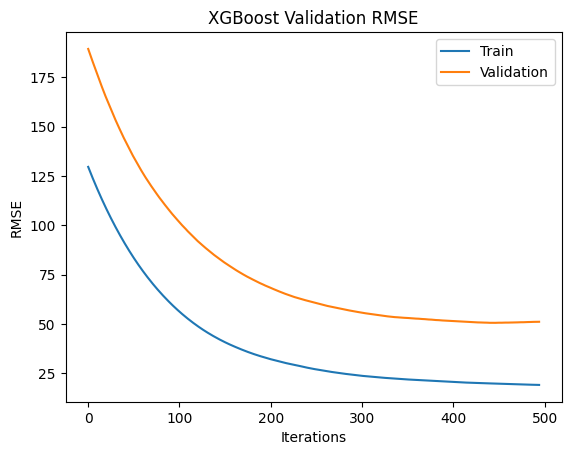

In [ ]:
model = xgb.XGBRegressor(
    n_estimators=2000,
    learning_rate=0.01,
    max_depth=4,
    early_stopping_rounds=50,
    random_state=42
)

# use callback-based early stopping to avoid unsupported keyword argument
model.fit(
    X_train, y_train,
    eval_set=[(X_train, y_train), (X_val, y_val)],
    verbose=False
)

evals_result = model.evals_result()

plt.plot(evals_result['validation_0']['rmse'], label='Train')

plt.plot(evals_result['validation_1']['rmse'], label='Validation')

plt.legend(['Train', 'Validation'])
plt.xlabel('Iterations')
plt.ylabel('RMSE')
plt.title('XGBoost Validation RMSE')

In [64]:
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
print(f"Test MSE for 2025: {mse:.4f}")

Test MSE for 2025: 4071.0557


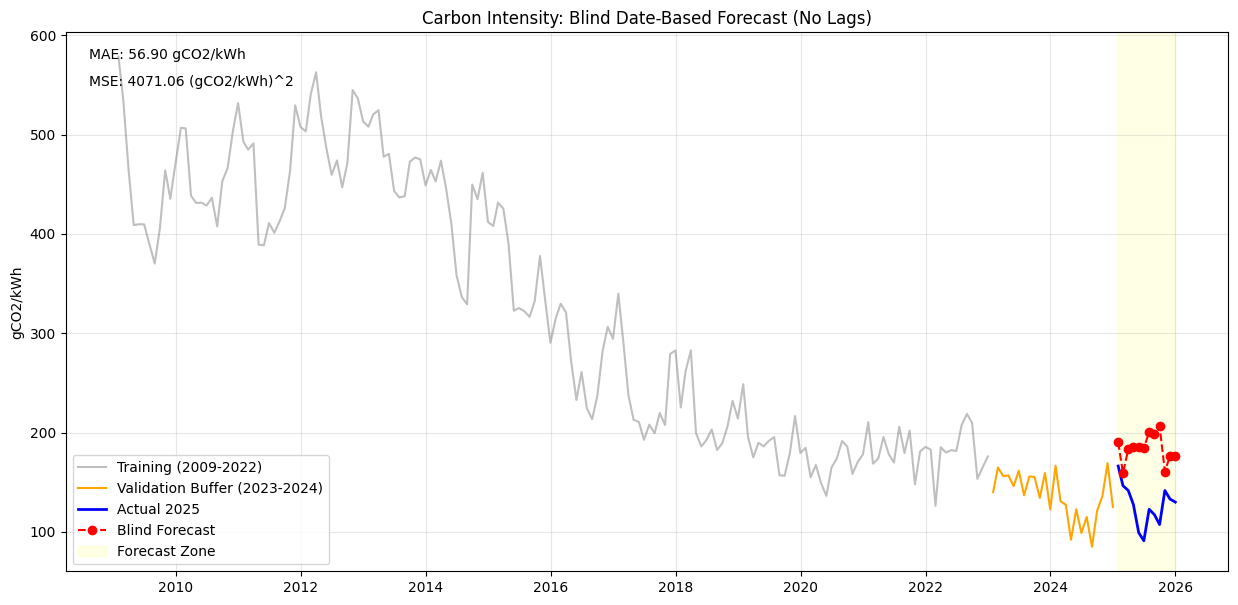

In [65]:
plt.figure(figsize=(15, 7))

# 1. Plot Historical Context
plt.plot(train['DATETIME'], y_train, color='gray', alpha=0.5, label='Training (2009-2022)')
plt.plot(val['DATETIME'], y_val, color='orange', label='Validation Buffer (2023-2024)')

# 2. Plot the Test Year (2025)
plt.plot(test['DATETIME'], y_test, color='blue', linewidth=2, label='Actual 2025')
plt.plot(test['DATETIME'], y_pred, color='red', linestyle='--', marker='o', label='Blind Forecast')

# 3. Formatting
plt.axvspan(test['DATETIME'].min(), test['DATETIME'].max(), color='yellow', alpha=0.1, label='Forecast Zone')
plt.title('Carbon Intensity: Blind Date-Based Forecast (No Lags)')

plt.text(0.02, 0.95, "MAE: {:.2f} gCO2/kWh".format(mae), 
         fontsize=10, color='black', transform=plt.gca().transAxes)
plt.text(0.02, 0.90, "MSE: {:.2f} (gCO2/kWh)^2".format(mse), 
         fontsize=10, color='black', transform=plt.gca().transAxes)

plt.ylabel('gCO2/kWh')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()